# Convolution in Practise

The fully connected layer that we saw doesn’t respect the spatial structure of the input. If, for example, the input is an image, the NN will destruct the 2D structure into a 1-dimensional vector. To address the issue, we have designed Convolutional Neural Networks (CNNs). They work exceptionally well for computer vision applications.

Convolutional layers exploit the local structure of the data.

Dot product between Image x Kernel = scalar which is a measure of similarity.
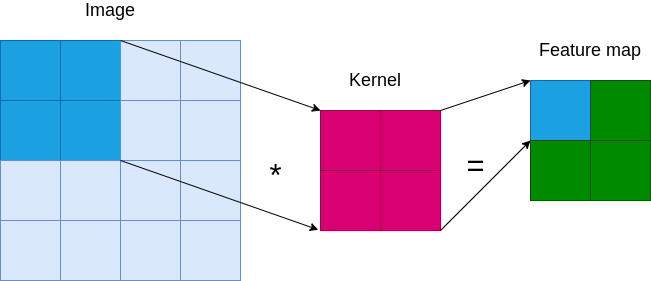!

Given an input matrix N×N and a kernel p×p, where p<N:

- We slide the filter across every possible position of the input matrix.
- At each position, we perform a dot-product operation and calculate a scalar.
- We gather all these scalar together to form the output, which is called the feature map.
  
We transformed a 2D matrix from the input space to the feature space but without losing the 2D form of the input. That way the network can capture context that only appears in parts of the image and would otherwise be lost by a fully connected layer.

- Convolution is still a linear operator.
- The weights that are in the kernel are trainable and are shared through the input.
- Each dot-product operation gives a notion of similarity.
- Convolutional layers can be performed in any number of dimensions.
- The axis that we slide the image on defines the dimension of a convolution. For images, it is a 2D convolution. But we can still apply convolutions in 1D sequences that have some kind of local structure.
  
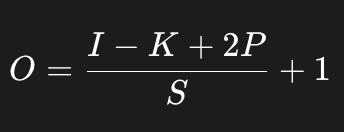
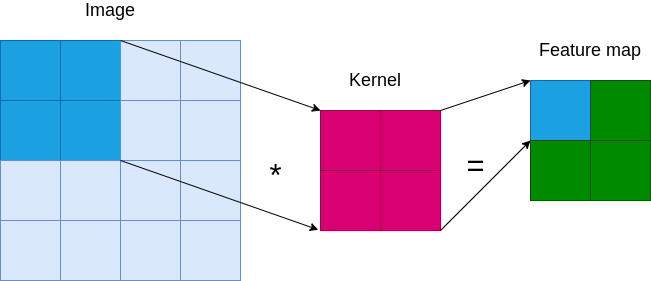
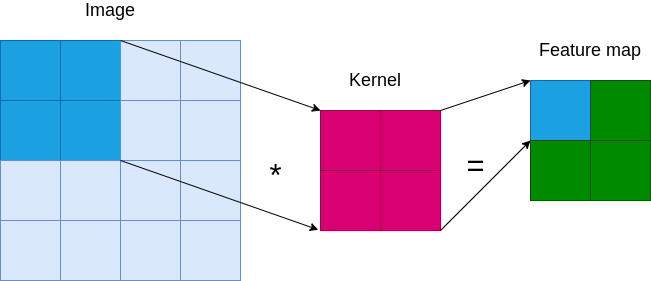
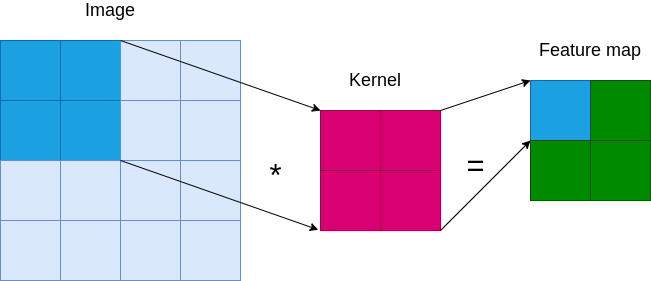

> The operation, element-wise multiply followed by a sum, is the definition of a convolution/correlation at a single location.

In [1]:
import torch
import torch.nn as nn

def conv2d(image, kernel):
    H, W = list(image.size())
    M, N = list(kernel.size())

    out= torch.zeros(H-M+1, W-N+1, dtype=torch.float32) # output dimensions
    for i in range(H-M+1):
        for j in range(W-N+1):
            out[i,j]= torch.sum(image[i:i+M,j:j+N]*kernel) # convolution
            # element wise multiplication then summation
            # results in a scalar for the position i,j
    return out

As you may have guessed, our learnable weights are now the values of our filters and can be trained with backpropagation, as usual. We can add a bias into each filter as well.

Convolutional layers can be stacked on top of others. Since convolutions are linear operators, we include non-linear activation functions in between just as we did in fully connected layers.

If your input has channels (like a color image with Red, Green, and Blue channels, C=3), the convolution operation also sums across the channel dimension to produce a single value for each output feature map.

In standard 2D convolution, the multiplication and summation process works across all three dimensions of the input volume (Height × Width × Channels).

In [2]:
# defining a 2D conv layer
conv_layer = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 5)
conv_layer

Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))

The above layer will receive an image of 3 channels (i.e., R,G,B) and will output 5 feature maps (channels) using a kernel size of 5x5x3. For simplicity, we just say 5x5 kernel.

The output of a convolutional layer is a 4D tensor representing the output feature map. Its dimensions are determined by the input shape, the kernel size, and the padding/stride (which is 1 and 0, respectively, in the standard nn.Conv2d default).

 1. The Number of Kernels (Feature Detectors)
    The out_channels value specifies exactly how many independent kernels (filters) the layer will use.
    
    In your example, out_channels=5 means the layer will initialize five separate, trainable kernels.
    
    Each of these five kernels learns to detect a different feature in the input (e.g., one kernel might learn to detect vertical edges, another might learn to detect specific textures, etc.).

2. The Depth of the Output Feature Map
    Each of the five kernels sweeps across the entire input volume and produces one single output map.
    
    Because you have five kernels, the layer produces five separate output maps.
    
    The final output tensor from this conv_layer will have a depth (or channel dimension) equal to out_channels.

#### How Kernels Create a 3D Tensor

Each of your 5 kernels produces a 2D output map, and these 5 maps are indeed stacked on top of each other to form a 3D tensor that is passed to the next layer.
    
Here's the structure:
    
Input Volume: Your input is 3 channels x H_in x W_in
Kernel Operation: Each of your 5 kernels performs a convolution across the entire depth (3 channels) and spatial area (H×W) of the input.
    
Single Output Map: Each single kernel collapses the input's depth (C_in =3) into one single 2D feature map.
    
Output Volume: The 5 resulting 2D maps are then concatenated along the channel dimension.

The resulting output for a single image is a 5 x H_out x W_out 3D tensor, where the "5" represents the new set of feature channels.

#### The Role of Batch Size (4D Tensor)
The batch size (N) is always the first dimension in PyTorch's convention and determines the total volume of data being processed simultaneously.

When you account for the batch size, the tensor you pass to the next layer is a 4D tensor:

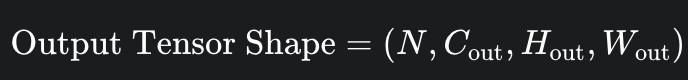

The convolution layer simply performs the full 3D convolution process (multiply and sum over C_in x H_kernel x W_kernel) independently for every image in the batch.

In [3]:
input_img = torch.rand(1,3,7,7)
layer = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, stride=2, padding=1)
out = layer(input_img)
print(out.shape) 

torch.Size([1, 6, 4, 4])


In short, you are defining the dimensions of the entire set of kernels used by the layer: C_out determines how many are created, and C_in determines the depth of each one.

# Pooling layer

Many popular CNN architectures utilize another type of layer besides the convolutional layer. This new layer is known as the pooling layer. Pooling layers can be thought of as a way to downsample the features without having any learnable parameters. In other words, pooling layers do not contribute to the training of a neural network. These layers function in a similar form as convolutional layers in terms that we apply a function on a chunk of the input and produce a single scalar number.

One reason that we may introduce pooling is that it adds invariance to minor spatial changes. For example, two tensors with slightly different translations will result in the same pooling map.

Another reason is that we want to gradually reduce the resolution of the input as we perform the forward pass. That’s because the deeper layers should have a higher receptive field, meaning that they should be more and more sensitive to the entire image.

After all, our ultimate goal is to classify if an image contains a cat or a dog and not detect the corners.

Finally, pooling makes the learned features more abstract.

In [4]:
input_img = torch.rand(1,3,8,8)
layer = nn.MaxPool2d(kernel_size=2, stride=2)
out = layer(input_img)
print(out.shape) 

torch.Size([1, 3, 4, 4])


# Build a Convolutional Network

The CNN structure will be:

- A conv layer with 3 channels as input, 6 channels as output, and a 5x5 kernel
- A 2x2 max-pooling layer
- A conv layer with 6 channels as input, 16 channels as output, and a 5x5 kernel
- A linear layer with 1655 nodes
- A linear layer with 120 nodes
- A linear layer with 84 nodes
- A linear layer with 10 nodes